In [2]:
import matplotlib
%matplotlib inline

import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns
sns.set()

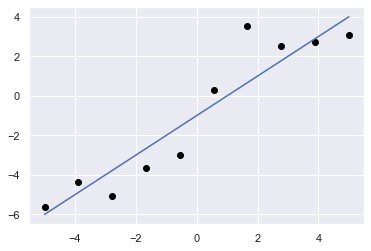

In [3]:
def model(x, weights):
    X = np.array([x**k for k in range(len(weights))]).transpose()
    return (X @ weights[:,np.newaxis]).flatten()

no_samples = 10

x = np.linspace(-5, 5, no_samples)

weights = np.array([-1, 1])
std_noise = 1.2

y_true = model(x, weights)
y_noisy = y_true + np.random.normal(0, std_noise, len(y_true))

plt.plot(x, y_true)
plt.scatter(x, y_noisy, color='black')
plt.show()

In [4]:
def log_prior(params, prior_scale_weights=1., prior_scale_noise=5.):
    if isinstance(prior_scale_weights, (float, int)):
        prior_scale_weights = [prior_scale_weights for _ in range(len(params)-1)]
    log_prior_weights = np.array([stats.norm.logpdf(w, loc=0, scale=psw) for w, psw in zip(params[:-1], prior_scale_weights)])
    log_prior_noise = stats.uniform.logpdf(params[-1], loc=0, scale=prior_scale_noise)
    return log_prior_weights.sum() + log_prior_noise

def log_likelihood(x, y, params, model):
    y_pred = model(x, params[:-1])
    log_likelihoods = stats.norm.logpdf(y, loc=y_pred, scale=params[-1])
    return np.sum(log_likelihoods)

def log_posterior(x, y, params, model):
    return log_likelihood(x, y, params, model) + log_prior(params)

In [5]:
def proposal_fct(params, scale_weights=0.5, scale_std_noise=0.5):
    if isinstance(scale_weights, (float, int)):
        scale_weights = [scale_weights for _ in range(len(params)-1)]
    return np.append(np.random.normal(loc=params[:-1], scale=scale_weights), np.random.normal(loc=params[-1], scale=scale_std_noise))

In [7]:
num_iter = 10000
burnin_iter = 5000

start_weights = np.array([0.5 for _ in range(2)])
start_std_noise = 0.5

chain = np.zeros((num_iter, len(start_weights) + 1))
chain[0] = np.append(start_weights, start_std_noise)

log_post = lambda p: log_posterior(x, y_noisy, p, model)

for i in tqdm(range(num_iter-1)):
    proposal = proposal_fct(chain[i])
    posterior_prob = np.exp(log_post(proposal) - log_post(chain[i]))
    if np.random.uniform(0, 1) < posterior_prob:
        chain[i+1] = proposal
    else:
        chain[i+1] = chain[i]

posterior_params = chain[burnin_iter:].mean(axis=0)

100%|██████████| 9999/9999 [00:13<00:00, 724.27it/s]


[-0.83073391  1.00491375  1.66315361]


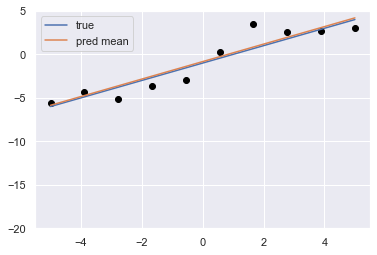

In [8]:
print(posterior_params)
plt.plot(x, y_true, label='true')
plt.plot(x, model(x, posterior_params[:-1]), label='pred mean')
plt.scatter(x, y_noisy, color='black')
plt.legend()
plt.ylim([-20, 5])
plt.show()

NameError: name 'y_preds' is not defined

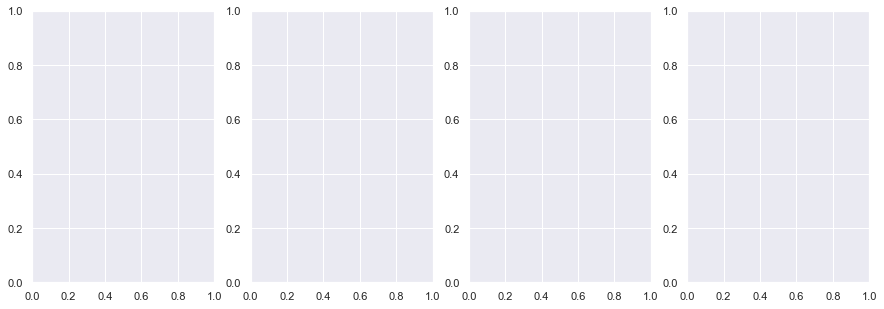

In [10]:
def posterior_pred(x, model, chain):
    return np.array([model(x, c[:-1]) for c in chain])

x_test = np.array([-10, 1, 3, 100], dtype=np.float32)

fig, ax = plt.subplots(1, len(x_test), figsize=(15,5))
for i in range(len(x_test)):
    y_pred = posterior_pred(x_test[i], model, chain[burnin_iter:])
    y_preds.append([y_pred.mean(), y_pred.std()])
    ax[i].hist(y_pred, bins=20)
    ax[i].axvline(y_pred.mean(), color='#D1895C', linestyle='--', linewidth=2, label='pred mean')
    ax[i].axvline(model(x_test[i], weights), color='r', linestyle='--', linewidth=2, label='true')
    ax[i].set_title(r'$\sigma(x=%.1f) = %.4f$' % (x_test[i], y_pred.std()) )

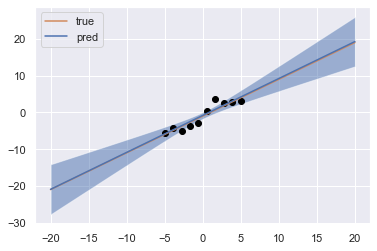

In [11]:
x_pred = np.linspace(-20, 20, 1000)
y_pred = posterior_pred(x_pred, model, chain[burnin_iter:])
y_pred_mean = y_pred.mean(axis=0)
y_pred_std = y_pred.std(axis=0)

y_true_pred = model(x_pred, weights)

plt.plot(x_pred, y_true_pred, color='#D1895C', label='true')
plt.plot(x_pred, y_pred_mean, label='pred')
plt.fill_between(x_pred, y_pred_mean + 2 * y_pred_std, y_pred_mean - 2 * y_pred_std, alpha=0.5)
plt.scatter(x, y_noisy, color='black')
plt.legend()
plt.show()